# Методы удаления шума

В этой работе рассмотрены три метода удаления шума с изображения. Метод Гаусса, Билатеральный и NLM.
Для тестирования работы алгоритмов взято изображение, к которому добавлен шум. В качестве метрики для определения колличественной характеристики успешности работы метода применяется функция sad(), вычисляющая разность между зашумленным изображением после обработки фильтром и исходным изображением.

In [1]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np
import scipy.ndimage as ndimg
from scipy.stats import norm

import math

from numba import jit, njit, prange, cfunc

In [2]:
def addNoise(img, sigma=1) :
    noise_img = img + norm.rvs(0, sigma, img.shape)
    noise_img[noise_img > 255] = 255
    noise_img[noise_img < 0] = 0
    return np.round(noise_img).astype(np.uint8)

def sad(a, b) :
    return np.mean(np.abs(a.astype(np.float64) - b.astype(np.float64)))

sad :  15.892822264389627


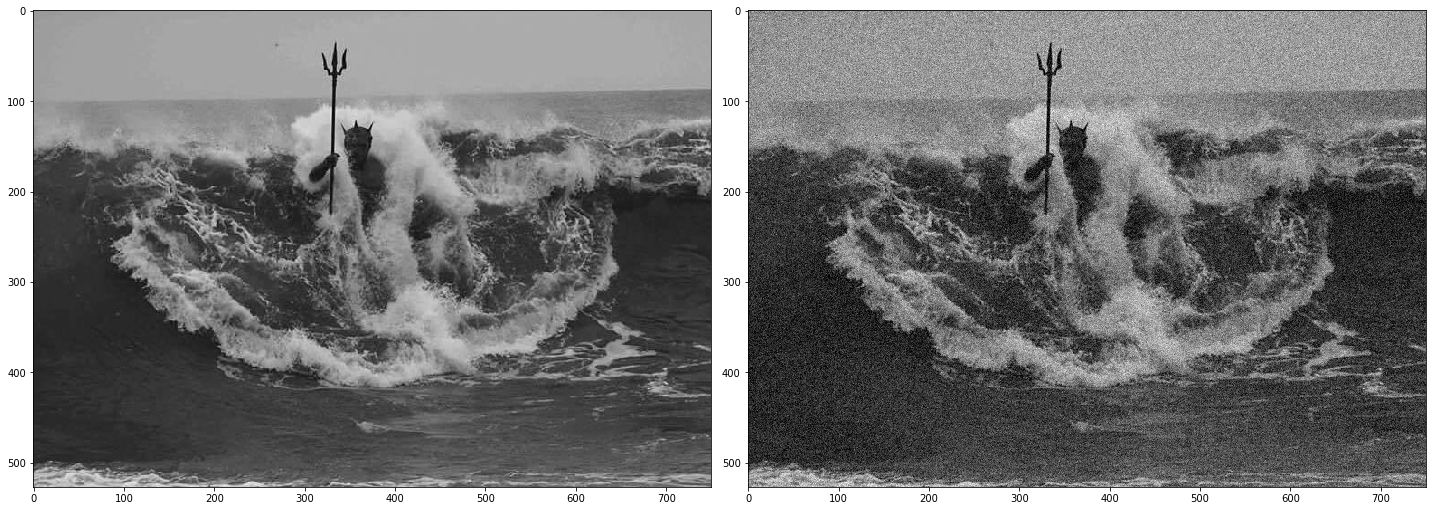

In [3]:
img1 = cv.imread('2.jpg', cv.IMREAD_GRAYSCALE)
img1 = img1.astype(np.float64)

img_N = addNoise(img1, 20)

print('sad : ', sad(img1,img_N))

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(img1,  cmap='gray')
axes[1].imshow(img_N, cmap='gray')
fig.tight_layout()

## Фильтр Гаусса

Основная идея метода в том, что используя фильтр Гаусса, который мы получаем из формулы нормального распределения, обходим изображение и в итоге получаем размытое изображение на выходе. Путём размытия можно избавиться от шума.

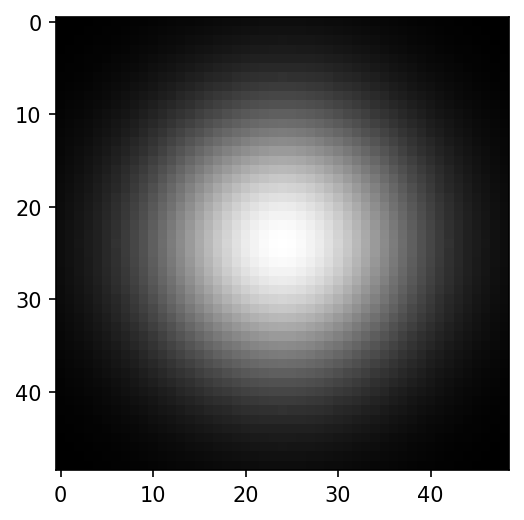

In [19]:
@njit
def gfunc(x,y,sigma):
    return (math.exp(-(x**2 + y**2)/(2*(sigma**2))))/(2*3.14*(sigma**2))

@njit
def gfunc_another(x,sko):
    return (math.exp(-(x**2)/(2*(sko**2))))/(2*3.14*(sko))

@njit
def gaussFilter(size=(50,50), sigma=10):
    out = np.zeros(size)
    for i in range(size[0]):
        for j in range(size[1]):
            out[i,j] = gfunc(i-size[0]//2,j-size[1]//2, sigma)
    return out/np.sum(out)

plt.figure(dpi=150)
plt.imshow(gaussFilter((49,49),10), cmap='gray')
plt.show()

6.109047438330171


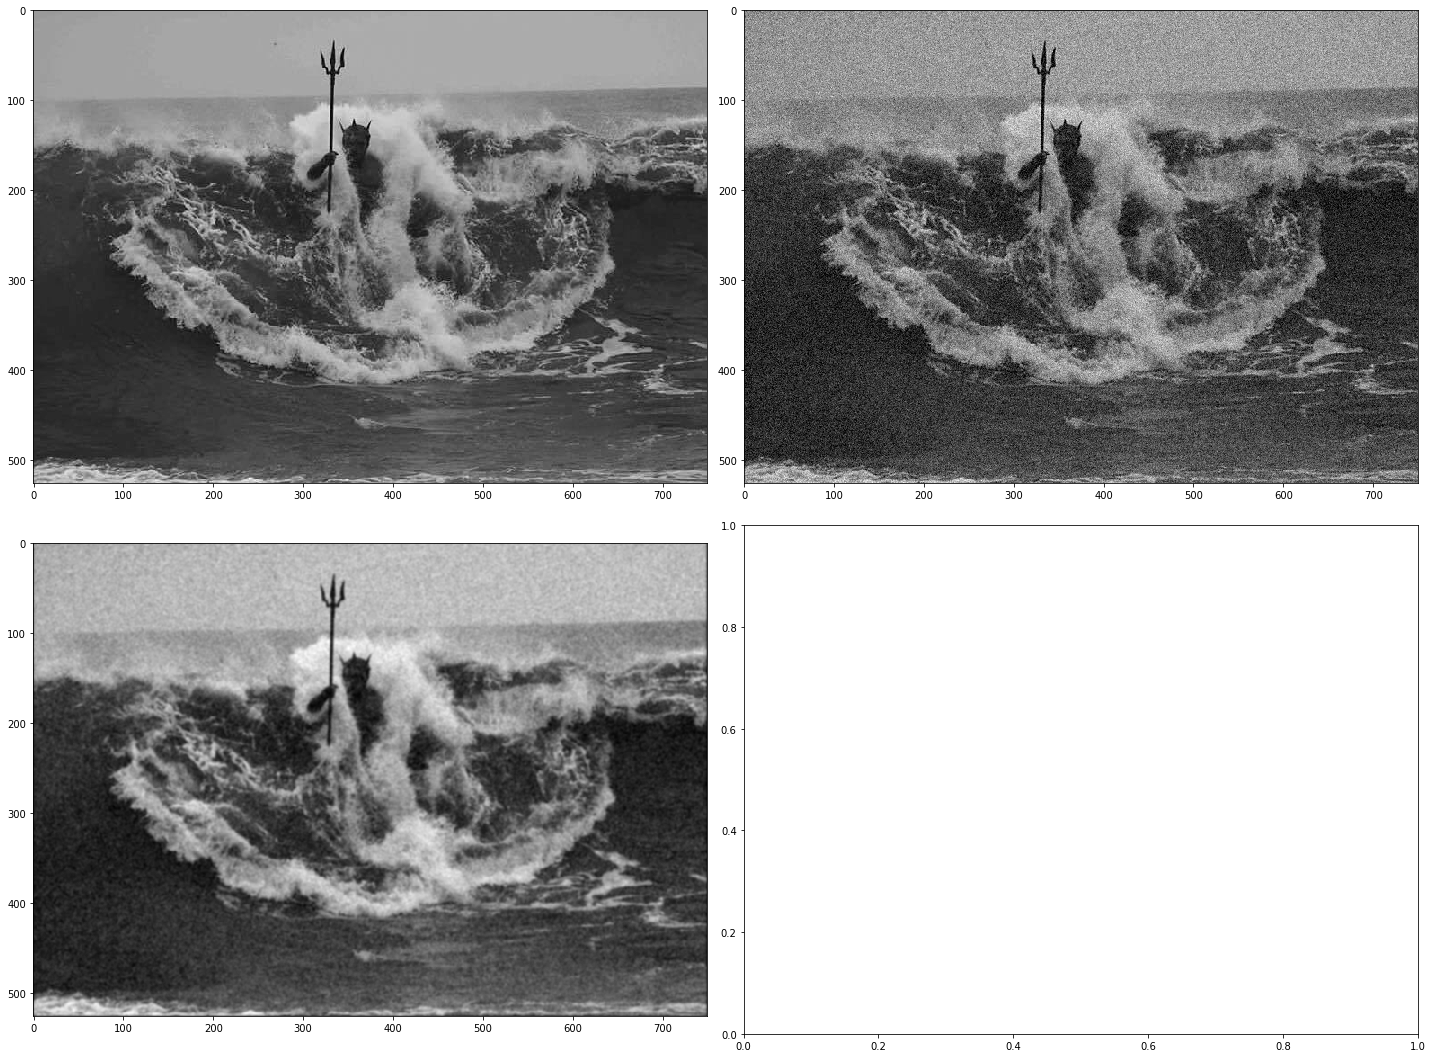

In [20]:
sigma = 12
size  = 1 + 4 * sigma
img_g = ndimg.convolve(img_N, gaussFilter((size,size), sigma/10), mode='constant')

print(sad(img1,img_g))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
axes[0,0].imshow(img1, cmap='gray')
axes[0,1].imshow(img_N, cmap='gray')
axes[1,0].imshow(img_g, cmap='gray')
fig.tight_layout()

i : 1.0, sad : 6.19825173940544
i : 1.1, sad : 6.123744465528147
i : 1.2, sad : 6.107559772296015
i : 1.3, sad : 6.133672359266287
i : 1.4, sad : 6.1862036685641995


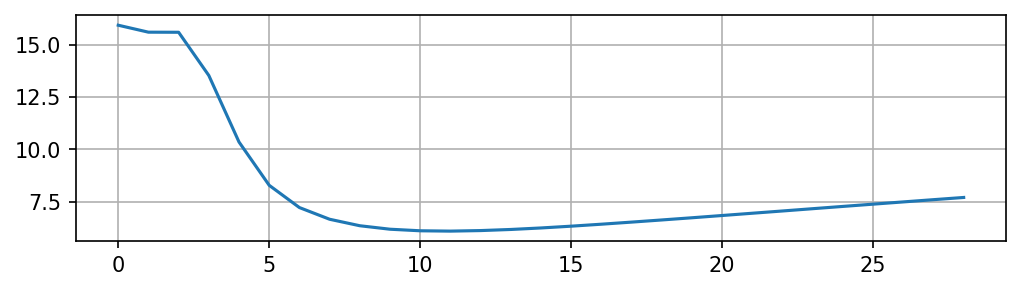

In [37]:
vector_size = 30
gaussian_sad = [0] * (vector_size-1)
for i in range(1,vector_size) : 
    size = 1 + 4 * i
    sad_val = sad(img1, ndimg.convolve(img_N, gaussFilter((size,size), i/10), mode='constant'))
    gaussian_sad[i-1] = sad_val
    if (sad_val < 6.2) :
        print(f'i : {i/10}, sad : {sad_val}')

plt.figure(dpi=150, figsize=(8, 2))
plt.grid()
plt.plot(gaussian_sad)
plt.show()

Видно, что наименьший sad достигается в районе i = 10, это соответствует sigma = 1. В целом метод понизил уровень шума на изображении, но визуальное качество изображения стало хуже, это связано с тем, что фильтр Гаусса не разбирает, того с чем он работает и размывает всё. Для того, чтобы решить эту проблему воспользуемся другим фильтром.

## Билатеральный фильтр

Улучшает идею фильтра Гаусса дополнительно меняя веса пикселов
в окрестности в зависимости от того, как сильно отличается их значение от
центрального пиксела. Чем сильнее разница между центральным пикселом
и окрестным, тем меньший вес имеет окрестный пиксел. Это равноценно
дополнительному применению фильтра Гаусса по значениям
интенсивностей. Фильтр работает медленно за счет своей нелинейности,
но в отличии от предыдущего фильтра не сглаживает границы объектов,
что полезно при работе с алгоритмами, опирающимися на извлечении
информации о контурах объектов.

In [47]:
@njit(parallel=True,fastmath=True)
def bilateral_filter(image, sigma_1 = 2, sigma_2 = 30) : 
    size = 1 + 4 * math.ceil(sigma_1)
    img = image.astype(np.float64)
    new_img = np.zeros(shape=image.shape)
    
    for i in range(size//2, image.shape[0] - size//2) :
#         if i%100 == 0 :
#             print(i/image.shape[0])
        for j in range(size//2, image.shape[1] - size//2) :
            
            left_border   = j - size//2
            right_border  = j + size//2 +1
            bottom_border = i + size//2 +1
            top_border    = i - size//2
            
            rec_img = img[top_border:bottom_border, left_border:right_border]
                        
            mask_img = np.zeros(shape=(size,size))
            
            for index_1 in range(size) :
                for index_2 in range(size) :
                    mask_img[index_1][index_2] = gfunc_another(img[top_border + index_1][left_border + index_2] - img[i][j], sigma_2)
                    
            mask_img = mask_img * gaussFilter((size,size),sigma_1)
            mask_img = mask_img / np.sum(mask_img)
            
            rec_img = rec_img * mask_img
            new_img[i][j] = np.sum(rec_img)
            
    return new_img
    
bil_img = bilateral_filter(img_N,1.5,73)

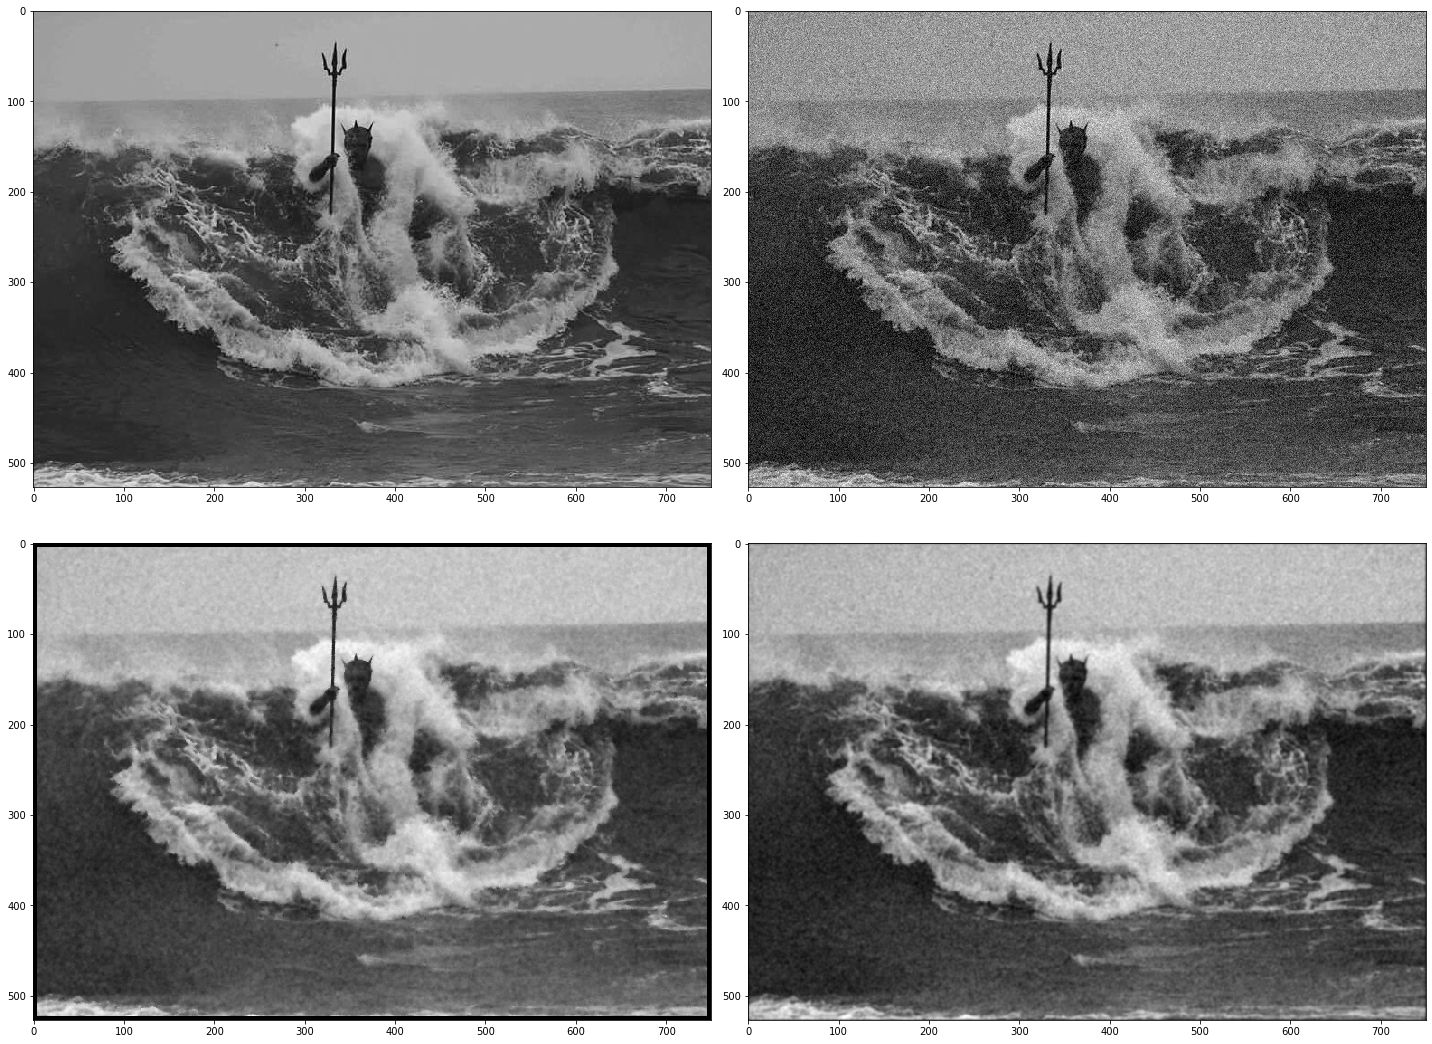

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
axes[0,0].imshow(img1, cmap='gray')
axes[0,1].imshow(img_N, cmap='gray')
axes[1,0].imshow(bil_img, cmap='gray')
axes[1,1].imshow(img_g, cmap='gray')
fig.tight_layout()

In [46]:
for i in range(15,16,1) : 
    for j in range(680,790,10) : 
        border  = 50
        delim = 10
        
        bil_img = bilateral_filter(img_N,i/delim,j/delim)
        img_1   = bil_img[border:img1.shape[0]-border,border:img1.shape[1]-border]
        img_2   = img1[border:img1.shape[0]-border,border:img1.shape[1]-border]
        
        sad_val = sad(img_1,img_2)
        print(f'i : {i/delim}, j : {j/delim}, sad : {sad_val}')

i : 1.5, j : 68.0, sad : 5.975902453435505
i : 1.5, j : 69.0, sad : 5.973847461321065
i : 1.5, j : 70.0, sad : 5.972319080772343
i : 1.5, j : 71.0, sad : 5.971292136124977
i : 1.5, j : 72.0, sad : 5.970737728769368
i : 1.5, j : 73.0, sad : 5.970596371688902
i : 1.5, j : 74.0, sad : 5.970826819129303
i : 1.5, j : 75.0, sad : 5.971384953076157
i : 1.5, j : 76.0, sad : 5.972241025682033
i : 1.5, j : 77.0, sad : 5.973374266716354
i : 1.5, j : 78.0, sad : 5.974755439286521


В ходе экспериментов была обнаружена область с наименьшими значениями sad. И в ней было произведено уточнение параметров. В итоге оптимальными оказались i : 1.5, j : 73.0, sad : 5.970596371688902

# Non Local Means
 
Традиционные алгоритмы шумоподавления усредняют
пиксели в пределах локального окна. Пиксели с близкими
значениями участвуют в усреднении с большими весами.
Алгоритм NLM отличается тем, что оценивается не близость
значений отдельных пикселей, а похожесть структуры их двумерных окрестностей. Благодаря этой особенности алгоритм NLM способен хорошо сохранять текстуры и подавлять на них шум. 

In [11]:
@njit(parallel=True,fastmath=True)
def nlm_filter(image, size=3, size_t=2, sigma = 1) :
    img = image.astype(np.float64)
    new_img = np.zeros(shape=image.shape)
    
    for i in range(size//2 + size_t//2, image.shape[0] - size//2 - size_t//2) :
        for j in range(size//2  + size_t//2, image.shape[1] - size//2 - size_t//2) :
            
            left_border   = j - size//2
            right_border  = j + size//2 +1
            bottom_border = i + size//2 +1
            top_border    = i - size//2
            
            rec_img = img[top_border:bottom_border, left_border:right_border]
            
            mask_img = np.zeros(shape=(size,size))
            
            origin_vector_color = img[i - size_t//2 : i + size_t//2, j - size_t//2 : j + size_t//2]
            
            for index_1 in range(size) :
                for index_2 in range(size) :
                    left_border_local   = left_border - size_t//2 + index_2
                    right_border_local  = left_border + size_t//2 + index_2
                    bottom_border_local = top_border  + size_t//2 + index_1
                    top_border_local    = top_border  - size_t//2 + index_1

                    vector_colors = img[top_border_local : bottom_border_local, left_border_local : right_border_local]
                    mask_img[index_1][index_2] = gfunc_another(np.linalg.norm(origin_vector_color - vector_colors)/(size*size),sigma)

            mask_img = mask_img / np.sum(mask_img)
            
            rec_img1 = rec_img * mask_img
            
            new_img[i][j] = np.sum(rec_img1)
            
    return new_img

In [13]:
nlm_img = nlm_filter(img_N,3,3,11)

img9  = nlm_img[30:img1.shape[0]-30,30:img1.shape[1]-30]
img10 = img1[30:img1.shape[0]-30,30:img1.shape[1]-30]

print(sad(img10,img9))

6.413415433359034


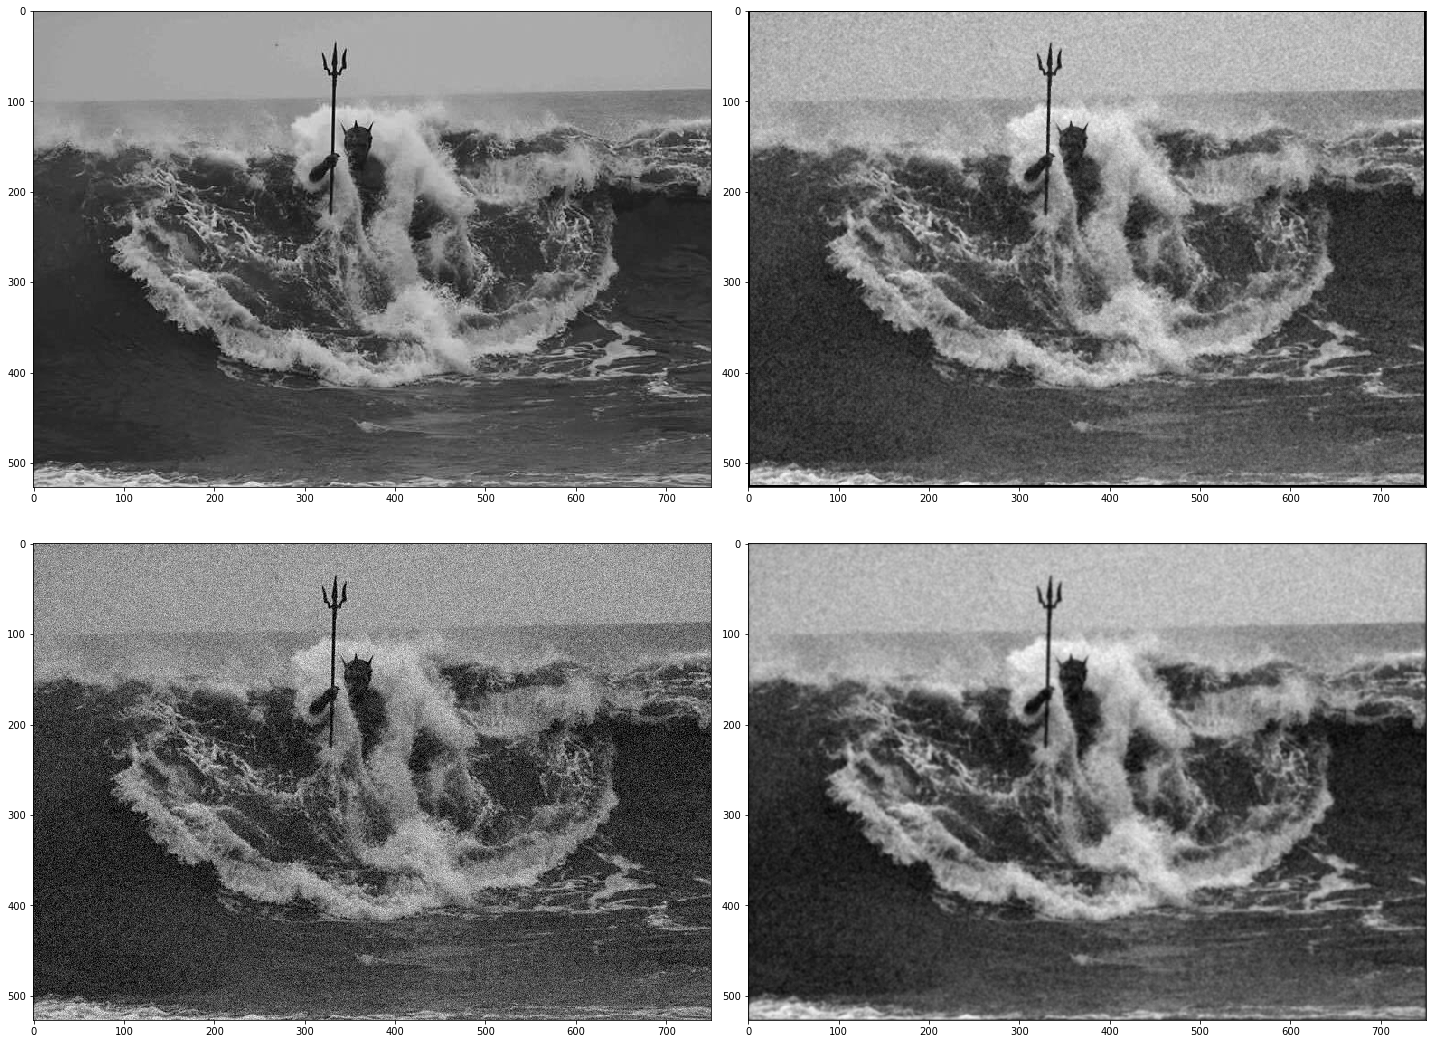

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
axes[0,0].imshow(img1, cmap='gray')
axes[0,1].imshow(nlm_img, cmap='gray')
axes[1,0].imshow(img_N, cmap='gray')
axes[1,1].imshow(img_g, cmap='gray')
fig.tight_layout()